In [1]:
import os
output_dir = "output/batch_benchmark"
os.makedirs(output_dir, exist_ok=True)


# Batch effect

## HVG

In [2]:
# Initialize 
source_path = "../REVISE/results"
task = "spot"
patient_id = "P2CRC"

result_path = f"{source_path}/{task}/{patient_id}"
data_path = f"../REVISE/data/{task}/{patient_id}"

parts = ["part3", "part1", "part2"]
batch_nums = [1, 2, 3, 4]
metrics = ["PCC", "SSIM", "MSE"]
spot_sizes = [50, 100, 150, 200]

gene_type = "HVG"
gene_num = 50

In [8]:
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def get_genes(result_path, data_path, part, spot_size, batch_num, gene_type = "HVG", gene_num = 50, test_genes = None): 
    ## Get HVG or HEG or ALL
    spot_path = os.path.join(data_path, f"cut_{part}", f"spot_{spot_size}")
    save_path = os.path.join(result_path, part, f"{spot_size}_{batch_num}", "select_gene")
    os.makedirs(save_path, exist_ok=True)

    gene_file = f"{save_path}/{gene_type}_{batch_num}_genes_{gene_num}.txt"
    if os.path.exists(gene_file):
        # print(f"Find {gene_type} genes in {gene_file}")
        with open(gene_file, "r") as f:
            genes = f.read().splitlines()
        return genes

    st_path = f"{spot_path}/xenium_spot.h5ad"
    adata = sc.read(st_path)
    if test_genes is not None:
        overlap_genes = [gene for gene in test_genes if gene in adata.var_names]
        adata = adata[:, overlap_genes]
    
    if gene_type == "HVG":
        sc.pp.filter_genes(adata, min_cells=1)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=gene_num)
        genes = adata.var[adata.var['highly_variable']].index.tolist()
    elif gene_type == "HEG":
        adata.var['sum'] = adata.X.toarray().sum(axis=0)
        adata.var.sort_values('sum', ascending=True, inplace=True)
        genes = adata.var.head(gene_num).index.tolist()
    else:
        genes = adata.var_names
    
    with open(gene_file, "w") as f:
        f.write("\n".join(genes))
    # print(f"Save {gene_type} genes to {gene_file}")

    return genes

def get_merge_df(result_path, data_path, part, metric, spot_sizes, batch_nums):

    merge_df = pd.DataFrame()
    for spot_size in tqdm(spot_sizes, desc="spot_sizes"):  
        for batch_num in batch_nums:
            metric_file = f"{result_path}/{part}/{spot_size}_{batch_num}/metrics_normalized.csv"
            df = pd.read_csv(metric_file, index_col=0)
            genes = get_genes(result_path, data_path, part, spot_size, batch_num, gene_type = gene_type, gene_num = gene_num, test_genes = df.index)
            df = df.loc[genes]

            df = pd.DataFrame({
                'Method': batch_num,
                'Value': df[metric].values,
                'Spot_size': spot_size,
                'Part': part,
                'Metric': metric,
            })
        
            merge_df = pd.concat([merge_df, df])
    merge_df.reset_index(drop=True, inplace=True)
    return merge_df

def plot_comp_seg(merge_df, metric, part, ax):
    
    spot_size_order = [50, 100, 150, 200]
    method_order = [1,2,3,4]
    custom_palette = {
        1: '#80a9c8',
        2: '#e89786',
        3: '#8ccfd9',
        4: '#b39a94',
    }
    # 画boxplot
    sns.boxplot(
        data=merge_df,
        x='Spot_size',
        y='Value',
        hue='Method',
        order=spot_size_order,
        hue_order=method_order,
        palette=[custom_palette[m] for m in method_order],
        width=0.6,
        fliersize=2,
        showfliers=False,
        ax=ax
    )
    # ax.set_title(f'{part}', fontsize=11, pad=8)
    # ax.set_xlabel('Spot Size', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.xaxis.set_visible(False)

    if metric == "PCC":
        ax.set_ylim(0, 1.02)
    elif metric == "SSIM":
        ax.set_ylim(0.5, 1.02)
    elif metric == "MSE":
        ax.set_ylim(1e-5, 1e-2)
        ax.set_yscale('log')

    if ax.get_legend() is not None:
        ax.legend_.remove()
    ax.set_aspect('auto')

spot_sizes:   0%|          | 0/4 [00:00<?, ?it/s]

spot_sizes: 100%|██████████| 4/4 [00:00<00:00, 166.11it/s]


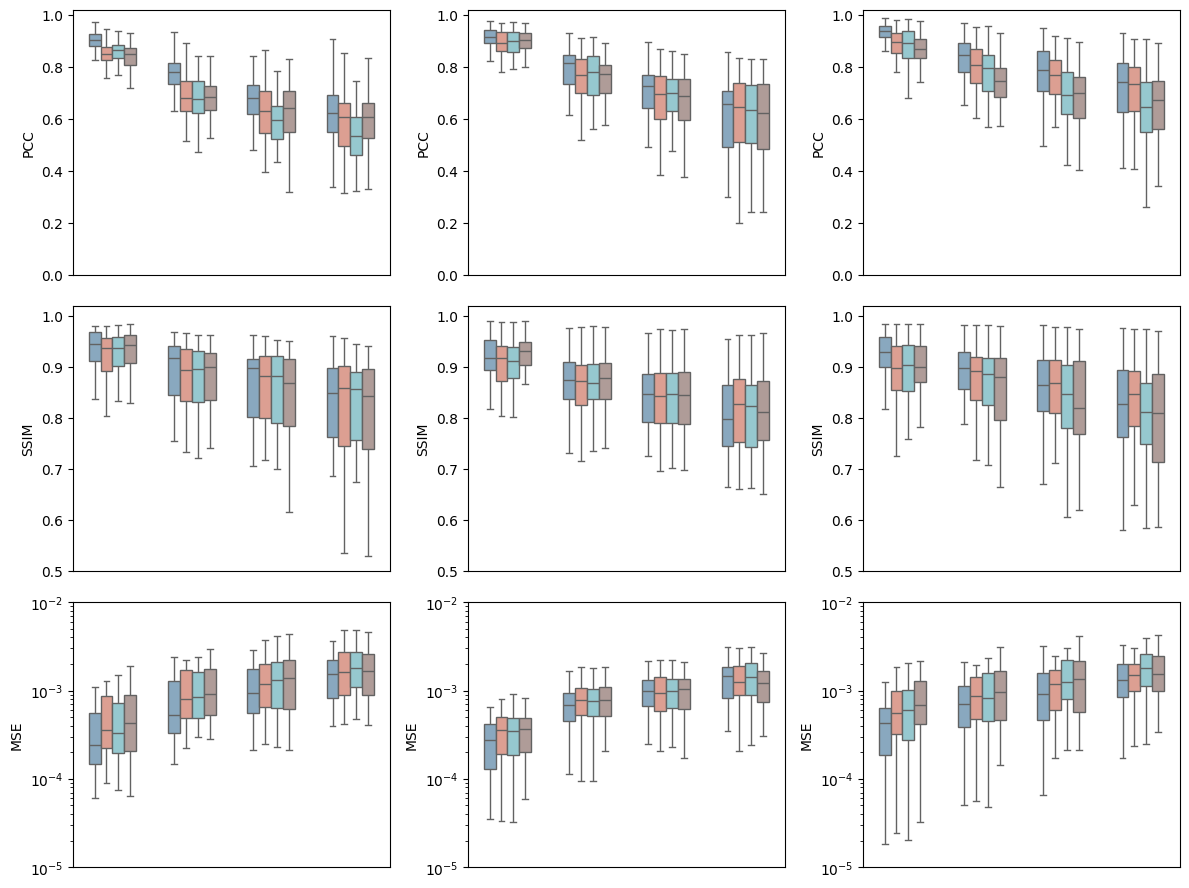

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, part in enumerate(parts):
    for j, metric in enumerate(metrics):

        merge_df = get_merge_df(result_path, data_path, part, metric, spot_sizes, batch_nums)
        
        ax = axes[j, i]
        plot_comp_seg(merge_df, metric, part, ax)

plt.tight_layout()
plt.savefig(f"{output_dir}/batch_effect_{gene_type}_{gene_num}.pdf", dpi=300)
plt.show()

## HEG

In [31]:
gene_type = "HEG"
gene_num = 50
def plot_comp_seg(merge_df, metric, part, ax):
    
    spot_size_order = [50, 100, 150, 200]
    method_order = [1,2,3,4]
    custom_palette = {
        1: '#80a9c8',
        2: '#b39a94',
        3: '#8ccfd9',
        4: '#e89786',
    }
    # 画boxplot
    sns.boxplot(
        data=merge_df,
        x='Spot_size',
        y='Value',
        hue='Method',
        order=spot_size_order,
        hue_order=method_order,
        palette=[custom_palette[m] for m in method_order],
        width=0.6,
        fliersize=2,
        showfliers=False,
        ax=ax
    )
    # ax.set_title(f'{part}', fontsize=11, pad=8)
    # ax.set_xlabel('Spot Size', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.xaxis.set_visible(False)

    if metric == "PCC":
        ax.set_ylim(-0.02, 1.02)
    elif metric == "SSIM":
        ax.set_ylim(0.5, 1.02)
    elif metric == "MSE":
        ax.set_ylim(1e-5, 1e-2)
        ax.set_yscale('log')

    if ax.get_legend() is not None:
        ax.legend_.remove()
    ax.set_aspect('auto')

spot_sizes:   0%|          | 0/4 [00:00<?, ?it/s]

spot_sizes: 100%|██████████| 4/4 [00:00<00:00, 162.52it/s]


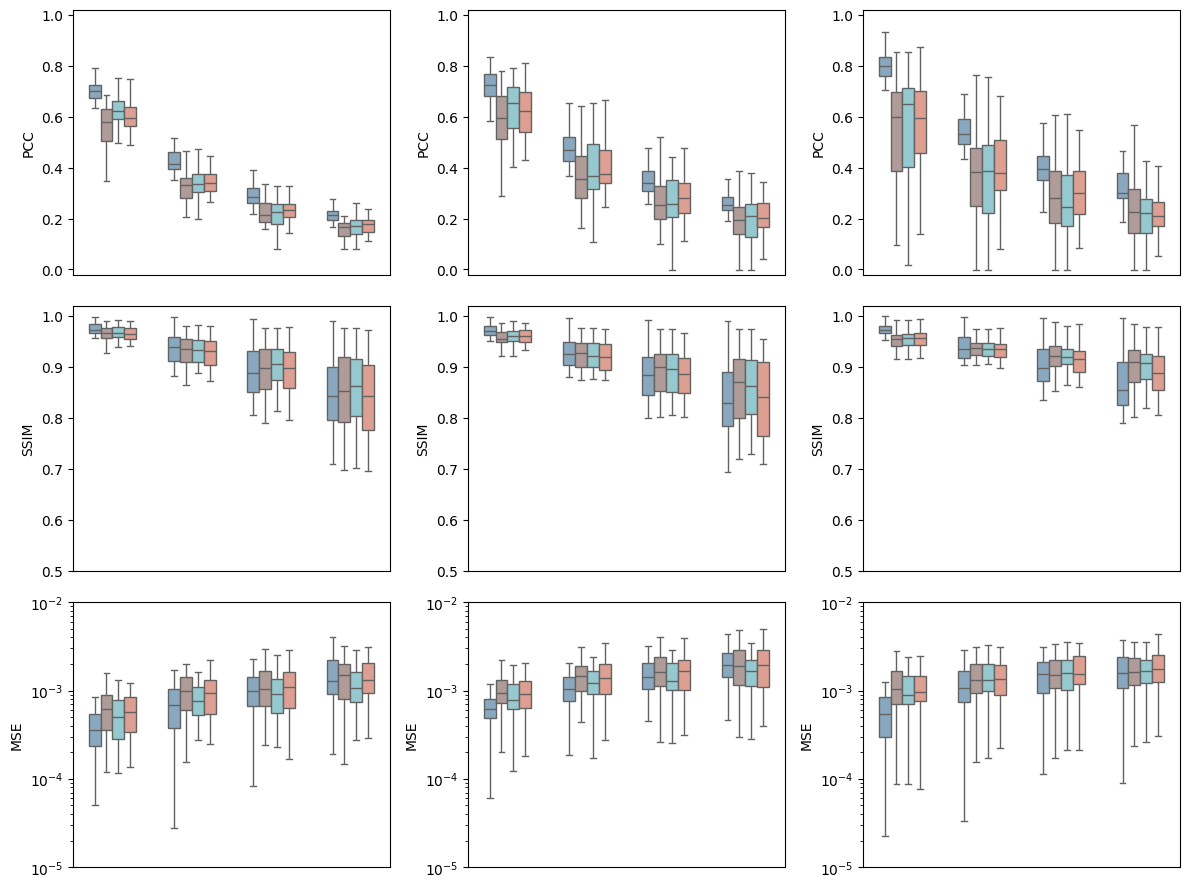

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, part in enumerate(parts):
    for j, metric in enumerate(metrics):

        merge_df = get_merge_df(result_path, data_path, part, metric, spot_sizes, batch_nums)
        
        ax = axes[j, i]
        plot_comp_seg(merge_df, metric, part, ax)

plt.tight_layout()
plt.savefig(f"{output_dir}/batch_effect_{gene_type}_{gene_num}.pdf", dpi=300)
plt.show()

## All genes

In [33]:
gene_type = "ALL"
def plot_comp_seg(merge_df, metric, part, ax):
    
    spot_size_order = [50, 100, 150, 200]
    method_order = [1,2,3,4]
    custom_palette = {
        1: '#80a9c8',
        2: '#b39a94',
        3: '#8ccfd9',
        4: '#e89786',
    }
    # 画boxplot
    sns.boxplot(
        data=merge_df,
        x='Spot_size',
        y='Value',
        hue='Method',
        order=spot_size_order,
        hue_order=method_order,
        palette=[custom_palette[m] for m in method_order],
        width=0.6,
        fliersize=2,
        showfliers=False,
        ax=ax
    )
    # ax.set_title(f'{part}', fontsize=11, pad=8)
    # ax.set_xlabel('Spot Size', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.xaxis.set_visible(False)

    if metric == "PCC":
        ax.set_ylim(-0.02, 1.02)
    elif metric == "SSIM":
        ax.set_ylim(0, 1.02)
    elif metric == "MSE":
        ax.set_ylim(1e-5, 1e-1)
        ax.set_yscale('log')

    if ax.get_legend() is not None:
        ax.legend_.remove()
    ax.set_aspect('auto')

spot_sizes: 100%|██████████| 4/4 [00:00<00:00, 151.33it/s]


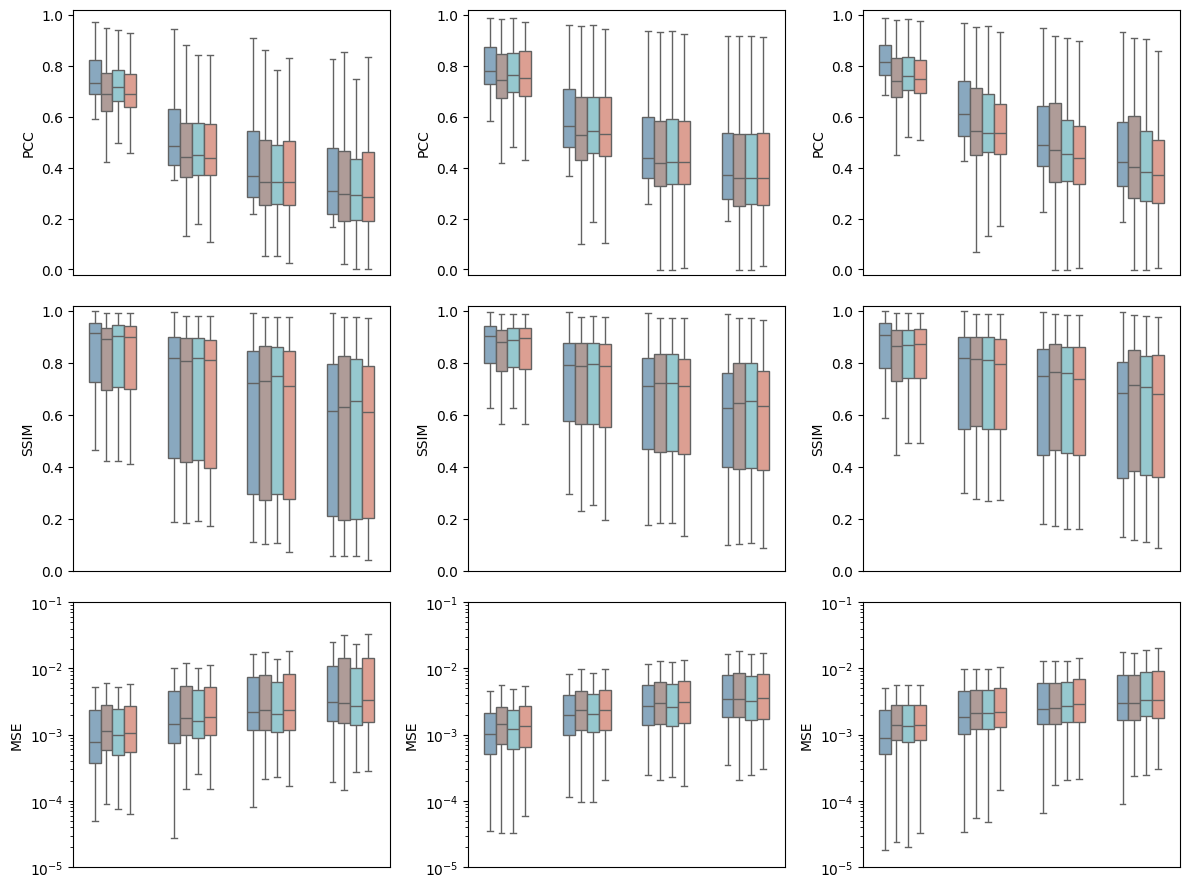

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, part in enumerate(parts):
    for j, metric in enumerate(metrics):

        merge_df = get_merge_df(result_path, data_path, part, metric, spot_sizes, batch_nums)
        
        ax = axes[j, i]
        plot_comp_seg(merge_df, metric, part, ax)

plt.tight_layout()
plt.savefig(f"{output_dir}/batch_effect_{gene_type}_{gene_num}.pdf", dpi=300)
plt.show()